#### Taken initial fund value, expected withdrawals, expected monthly return, inflation and Fisher management fee,
#### simulate fund values over time using Monte Carlo

In [2]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

from generateRandomSample import generateRandomSample

In [3]:
def getData():
    # Get the historical monthly returns from MSCI World
    df = pd.read_csv('~/data/retirement/benchmark/MSCI_world-v1.csv')
    df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x))
    df.rename(columns={'Date': 'date', 'MSCI World': 'value'}, inplace=True)
    return df

In [4]:
def filterDate(startDT):
    # Filter by date, format yyyy-mm-01. Earliest is 1978-12-01
    return df[df['date'] >= startDt]

In [5]:
def getRate(df):
    # Return the average monthly growth rate
    initVal = df.iloc[0]['value']
    finalVal = df.iloc[-1]['value']
    numMonths = len(df)-1
    return 1+npf.rate(nper=numMonths, pmt=0, pv=-initVal, fv=finalVal)

In [6]:
def getFundval(fundVal, data, fee):
    for wd, ret in data:
        if withdrawalFirst:
            fundVal -= wd
            fundVal *= ret
        else:
            fundVal *= ret
            fundVal -= wd
        fundVal *= fee
    return int(fundVal)

In [7]:
def calcFee():
    # This is the fee paid to Fisher: 1.15 %
    fee = 1+npf.rate(nper=12, pmt=0, pv=-100, fv=98.85)
    print("Fisher fee turns $100 into {:.2f} after 12 months".format(100*np.power(fee, 12)))
    return fee

In [8]:
def calcMetrics(df):
    # Compute the monthly growth rate of MSCI plus the std dev of monthly returns
    rate = getRate(df)
    # Compute the Standard Deviation of monthly returns
    df['prev'] = df['value'].shift(1)
    df['pctChg'] = (df['value']-df['prev'])/df['prev']
    std = df['pctChg'].std()
    return rate, std

##### Set some constants

In [84]:
# Initial fund value
initFund = 3e6
# Initial monthly withdrawal amount
initWD = int(11000)
# Annual inflation rate
annualInflationRate = 0.022
# How far out to forecast
numYears = 30
# Do you withdraw first or apply the return first?
withdrawalFirst = False
# Filter on the MSCI data
startDt = '1978-12-01'

In [85]:
fcastLength = numYears * 12
monthlyInflationRate = 1+npf.rate(nper=12, pmt=0, pv=-100, fv=100*(1+annualInflationRate))
withdrawals = [initWD *np.power(monthlyInflationRate, x) for x in range(fcastLength)]

##### Get the MSCI historical data and compute some metrics

In [86]:
df = getData()
df = filterDate(startDt)

monthlyGrowthRate, std = calcMetrics(df)

In [125]:
# This is a 9% annualized rate, which is about what we should plan on
monthlyGrowthRate = 1.007207323316205

In [126]:
# What is the annualized growth rate, given the monthly rate?
fv = npf.fv(monthlyGrowthRate-1, nper=12, pmt=0, pv=-100)
print("MSCI return annualized: {:.2%}".format((fv-100)/100))

MSCI return annualized: 9.00%


In [136]:
# Compute the monthly fee paid to Fisher
fee = calcFee()

# Turn the fee off to see the affect of the 1.2%
#fee=1.0

Fisher fee turns $100 into 98.85 after 12 months


In [137]:
# Run a series of simulations
# For each simulation, generate monthly returns drawn from the Normal distribution
l = []
highVal = []
lowVal = []
for _ in range(10000):
    returns = generateRandomSample(monthlyGrowthRate, std, fcastLength)
    data = zip(withdrawals, returns)
    endingVal = getFundval(initFund, data, fee)
    l.append(endingVal)
    if endingVal > 2e7:
        highVal.append(returns)
    elif endingVal < 0:
        lowVal.append(returns)
    
neg = [x for x in l if x < 0]
below0 = len(neg) / len(l)
print("{:.0%} likelihood of running below 0".format(below0))

26% likelihood of running below 0


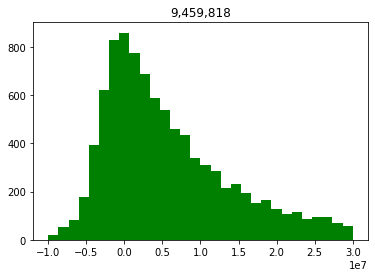

In [138]:
plt.hist(l, 30, range=[-1e7, 3e7], facecolor='green', align='mid')
plt.title("{:,}".format(int(sum(l)/len(l))))
plt.show()

In [117]:
h = pd.Series([y for x in highVal[:60] for y in x])
l = pd.Series([y for x in lowVal[:60] for y in x])

In [118]:
ratio = h.mean()/l.mean()

In [121]:
np.power(h.mean(), 360)

51.40490330536845

In [122]:
np.power(monthlyGrowthRate, 360)

23.071829506873392

In [123]:
np.power(l.mean(), 360)

8.953482971198758